# AFSK Demodulator
## Step 2: Band Pass FIR Filter

-----

This notebook will outline the steps necessary to move the band-pass FIR filter to FPGA.

This code is part of the [AFSK Demodulator on Pynq](afsk-demodulator-fpga.ipynb) project.

The purpose of this code is to serve as the foundation for migrating the Python demodulator code to FPGA.  We will be streaming audio data into the FPGA and streaming processed data out from the FPGA.

This is the first step of moving a demodulator processing step into the FPGA.

## Prerequisites

At this point you are expected to have:

 * A configured PYNQ environment.
 * Vivado installed on your computer and configured for your board.
 * Experience working through the tutorials at https://pynq.readthedocs.io/.
 * Familiarized yourself with the AFSK demodulator implementation in Python.
 * Completeed the first step of the tutorial to familiarize yourself with the process of creating a streaming interface.

## Outline

We are going to modify the IP we created in the first tutorial to do FIR processing.  We are going to use Python to generate the FIR coefficients (the same coefficients used in Python).

We will perform the following steps in this section:

 1. Create a C++ file that accepts a block of 16-bit data, performs the FIR operation, and sends the result back.
 1. Create a C++ test case for the above file (because good tests improve development speed).
 1. Generate an IP package from the code that can be used in Vivado.
 1. Create a Zynq project in Vivado that uses the IP.
 1. Export the bitstream for our project from Vivado.
 1. Use Python running on the PS to load the bitstream to the PL, and verify that it works.
 1. Integrate the FIR filter with the existing demodulator code, replacing the existing Python BPF.

First we are going to generate the FIR filter coefficients.  Then we are going to generate some sample data for our test bench. 

## Filter Coefficients

With the code below we will generate and output the coefficients for the band pass filter.  We are going to create a `cformat()` function that will allow us to copy/paste the output into a C/C++ file for HLS.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
from scipy.signal import lfiltic, lfilter, firwin, freqz
from scipy.io.wavfile import read

audio_file = read('../base/TNC_Test_Ver-1.102-26400-1sec.wav')
sample_rate = audio_file[0]
audio_data = audio_file[1]

bpf_coeffs = np.array(firwin(141, [1100.0/(sample_rate/2), 2300.0/(sample_rate/2)], width = None,
        pass_zero = False, scale = True, window='hann') * 32768, dtype=int)

def cformat(data):
    for i in range(0, len(data), 12):
        for j in range(12):
            if i + j == len(data): break
            print("{:6d}".format(data[i + j]), end=",")
        print()
    print()


cformat(bpf_coeffs)

     0,     0,     0,     0,     0,     0,     1,     3,     5,     8,     8,     5,
    -2,   -13,   -27,   -40,   -46,   -44,   -32,   -12,    11,    32,    44,    44,
    32,    14,     0,    -2,    13,    49,    97,   143,   170,   160,   104,     6,
  -118,  -244,  -340,  -381,  -352,  -258,  -120,    24,   138,   192,   173,    97,
     0,   -67,   -56,    62,   287,   575,   850,  1021,  1001,   737,   228,  -462,
 -1216, -1879, -2293, -2336, -1956, -1182,  -133,  1008,  2030,  2736,  2988,  2736,
  2030,  1008,  -133, -1182, -1956, -2336, -2293, -1879, -1216,  -462,   228,   737,
  1001,  1021,   850,   575,   287,    62,   -56,   -67,     0,    97,   173,   192,
   138,    24,  -120,  -258,  -352,  -381,  -340,  -244,  -118,     6,   104,   160,
   170,   143,    97,    49,    13,    -2,     0,    14,    32,    44,    44,    32,
    11,   -12,   -32,   -44,   -46,   -40,   -27,   -13,    -2,     5,     8,     8,
     5,     3,     1,     0,     0,     0,     0,     0,     0,



#### Note
The coefficients, once they have been scaled and turned into integers, have a
number of zeros at the start and end of the sequence.  Let's see what happens
when we remove them.  Let's graph the filter response in the frequency domain.

<IPython.core.display.Javascript object>


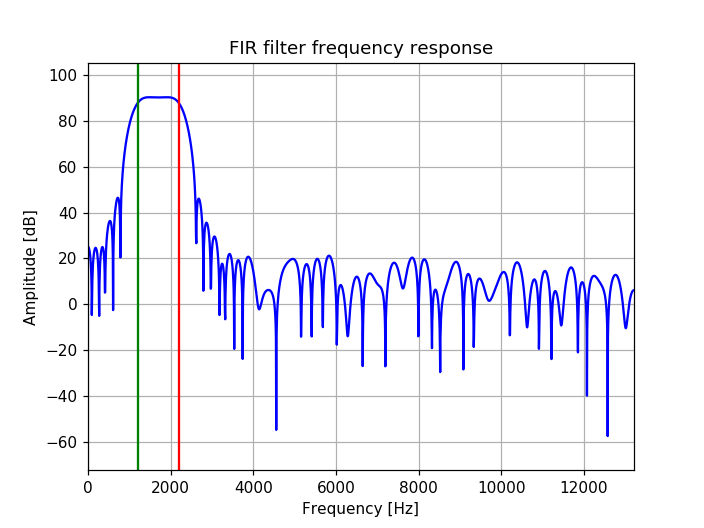

In [2]:
def plot_to_notebook(coeffs, sample_rate):
    plt.figure()
    plt.subplot(1, 1, 1)
    w, h = freqz(coeffs, 1, worN = 2000)
    plt.plot((sample_rate * 0.5 / np.pi) * w, 20 * np.log10(abs(h)), 'b')
    plt.title('FIR filter frequency response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.xlim(0, sample_rate/2)
    plt.axvline(1200, color='green') # cutoff frequency
    plt.axvline(2200, color='red') # cutoff frequency

plot_to_notebook(bpf_coeffs, sample_rate)

Above is the filter response of the complete set of coefficients.

Now lets see what happens to the response when we remove the zeros at the start and end.  We will also print out the trimmed set of coefficients.

<IPython.core.display.Javascript object>


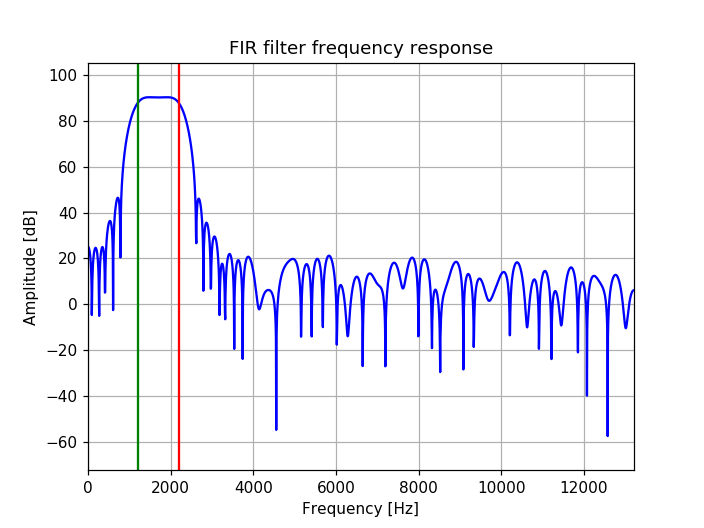

     1,     3,     5,     8,     8,     5,    -2,   -13,   -27,   -40,   -46,   -44,
   -32,   -12,    11,    32,    44,    44,    32,    14,     0,    -2,    13,    49,
    97,   143,   170,   160,   104,     6,  -118,  -244,  -340,  -381,  -352,  -258,
  -120,    24,   138,   192,   173,    97,     0,   -67,   -56,    62,   287,   575,
   850,  1021,  1001,   737,   228,  -462, -1216, -1879, -2293, -2336, -1956, -1182,
  -133,  1008,  2030,  2736,  2988,  2736,  2030,  1008,  -133, -1182, -1956, -2336,
 -2293, -1879, -1216,  -462,   228,   737,  1001,  1021,   850,   575,   287,    62,
   -56,   -67,     0,    97,   173,   192,   138,    24,  -120,  -258,  -352,  -381,
  -340,  -244,  -118,     6,   104,   160,   170,   143,    97,    49,    13,    -2,
     0,    14,    32,    44,    44,    32,    11,   -12,   -32,   -44,   -46,   -40,
   -27,   -13,    -2,     5,     8,     8,     5,     3,     1,



In [3]:
trimmed_bpf_coeffs = bpf_coeffs[6:-6]

plot_to_notebook(trimmed_bpf_coeffs, sample_rate)
cformat(trimmed_bpf_coeffs)

The filter response is indistinguishable from the one with the zeros.  It will be more efficient to use fewer coefficients in our design.

The above output are the filter coefficients we wil use for our bandpass filter.

## Test Bench Data

We will now generate the input and output data for our test bench.  Because we have a working Python model to work from, we will use its data as a baseline.

In [4]:
class fir_filter(object):
    def __init__(self, coeffs):
        self.coeffs = coeffs
        self.zl = lfiltic(self.coeffs, 32768, [], [])
    def __call__(self, data):
        result, self.zl = lfilter(self.coeffs, 32768, data, -1, self.zl)
        return result

bpf = fir_filter(trimmed_bpf_coeffs)

data = bpf(audio_data[:264])

print("Audio Input")
cformat(audio_data[:264])
print("Filtered Audio")
cformat(np.array(data, dtype=np.int))

Audio Input
   719,   748,   468,   487,   533,   880,  1187,  1717,  2124,  2262,  2417,  2371,
  2106,  1794,  1275,   690,     3,  -721, -1382, -1855, -2227, -2378, -2383, -2243,
 -1953, -1510,  -958,  -291,   214,   497,   833,   909,   818,   620,   290,  -207,
  -787, -1396, -2019, -2434, -2756, -2914, -2901, -2762, -2424, -1954, -1371,  -667,
   -66,   270,   638,   762,   762,   682,   490,   235,   100,   161,   280,   583,
   913,  1391,  1576,  1634,  1685,  1398,  1093,   658,   255,    94,     2,   105,
   349,   761,  1288,  1898,  2303,  2564,  2793,  2744,  2612,  2264,  1851,  1280,
   586,  -143,  -830, -1336, -1795, -1993, -2038, -1917, -1622, -1209,  -646,    28,
   598,   929,  1265,  1382,  1330,  1190,   843,   387,  -157,  -776, -1420, -1866,
 -2227, -2379, -2346, -2193, -1868, -1409,  -796,  -111,   557,   949,  1380,  1636,
  1604,  1550,  1310,   946,   449,  -113,  -744, -1260, -1629, -1888, -1907, -1800,
 -1579, -1171,  -623,    23,   707,  1176,  1579,  18

/usr/lib64/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/usr/lib64/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/usr/lib64/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(s

The data above represents 10ms of audio data, which is enough to get us started.

## Vivado HLS

A good resource for this section is [Vivado Design Suite
User Guide - High Level Synthesis (UG902)](https://www.xilinx.com/support/documentation/sw_manuals/xilinx2017_4/ug902-vivado-high-level-synthesis.pdf).  This documents the FIR function we will be using.

 1. Start Vivado HLS.
    ```bash
    vivado_hls
    ```
 1. Create a new project under the project_02 directory call HLS.
 1. Create a top-level function called demodulate.
 1. Create 2 new files:
    * [demodulate.hpp](HLS/demodulate.hpp)
    * [demodulate.cpp](HLS/demodulate.cpp)
 1. Create a new test bench:
    * [demodulate_test.cpp](HLS/demodulate_test.cpp)
 1. Update the project settings (right click on "HLS" in the Explorer pane)
    * Modify the CFLAGS for Simulation and Synthesis to include "-std=c++11"
 1. Update the solution settings (right click on "solution1" in the Explorer pane)
    * Go into "Solution Settings..."
    * Make sure "General" is selected in the left pane, then click "Add..."
    * Select "config_core" from the drop-down list.
    * Set the "core" parameter to "DSP48"
    * Set the "latency" parameter to 1.
 
The important part of this module is to implement the AXI streaming interface in C++ that we will be using for the remainder of the projects.  There are two important steps:

 1. Defining the C++ data types required for an AXI streaming interface.
 1. Adding the HLS `pragma` entries to the code.

-----

This is the header:

```c++
// Copyright 2019 Mobilinkd LLC.

#pragma once

#include <ap_axi_sdata.h>
#include <hls_stream.h>
#include <ap_int.h>

#define BPF_COEFF_LEN 129

typedef ap_axis<16,0,0,0> iodata_type;
typedef hls::stream<iodata_type> stream_type;

void demodulate(stream_type& input, stream_type& output);

```

And this is the source:

```c++
// Copyright 2019 Mobilinkd LLC.

#include "demodulate.hpp"

const ap_int<13> bpf_coeffs[] =
{
	     1,     3,     5,     8,     8,     5,    -2,   -13,   -27,   -40,   -46,   -44,
	   -32,   -12,    11,    32,    44,    44,    32,    14,     0,    -2,    13,    49,
	    97,   143,   170,   160,   104,     6,  -118,  -244,  -340,  -381,  -352,  -258,
	  -120,    24,   138,   192,   173,    97,     0,   -67,   -56,    62,   287,   575,
	   850,  1021,  1001,   737,   228,  -462, -1216, -1879, -2293, -2336, -1956, -1182,
	  -133,  1008,  2030,  2736,  2988,  2736,  2030,  1008,  -133, -1182, -1956, -2336,
	 -2293, -1879, -1216,  -462,   228,   737,  1001,  1021,   850,   575,   287,    62,
	   -56,   -67,     0,    97,   173,   192,   138,    24,  -120,  -258,  -352,  -381,
	  -340,  -244,  -118,     6,   104,   160,   170,   143,    97,    49,    13,    -2,
	     0,    14,    32,    44,    44,    32,    11,   -12,   -32,   -44,   -46,   -40,
	   -27,   -13,    -2,     5,     8,     8,     5,     3,     1,
};


template <typename InOut, typename Filter, size_t N>
inline ap_int<16> fir_filter(InOut x, InOut (&shift_reg)[N], Filter (&coeff)[N], size_t shift = (InOut::width - 1))
{
#pragma HLS pipeline II=2
    ap_int<36> accum{0};
    filter_loop: for (size_t i = N-1 ; i != 0; i--)
    {
        InOut tmp = shift_reg[i-1];
        shift_reg[i] = tmp;
        ap_int<InOut::width + Filter::width> tmp2 = tmp * coeff[i];
        accum += tmp2;
    }

    shift_reg[0] = x;
    accum += (x * coeff[0]);

    return static_cast<ap_int<16>>(accum >> shift);
}

void demodulate(stream_type& input, stream_type& output)
{
#pragma HLS INTERFACE axis port=input
#pragma HLS INTERFACE axis port=output
#pragma HLS interface ap_ctrl_none port=return

	iodata_type idata;
	iodata_type odata;

	static ap_int<16> bpf_shift_reg[BPF_COEFF_LEN];
#pragma HLS ARRAY_PARTITION variable=bpf_shift_reg complete dim=1

	demod_loop: while (!input.empty())
	{
		input >> idata;
		odata.data = fir_filter(idata.data, bpf_shift_reg, bpf_coeffs);
		odata.keep = 1;
		odata.strb = idata.strb;
		odata.last = idata.last;
		output << odata;
	}
}
```


-----

The `ap_axis` template type is specialized for a 16-bit transfer.  The three 0's are for fields we are not using, but which are required as they are part of the data type (User, ID and Dest).  This is the element type used for input and output.

We are changing things up a bit here by using an `hls::stream` to pass data into and out of our top-level function.  This gives us added flexibility for specifying how data is transferred.

Note also that we provide an `HLS pipeline` directive in the FIR filter code.  This will cause the entire FIR filter loop to be unrolled.  This is great for performance, at the expense of FPGA resources.  This consumes a large number of the DSP48 blocks.  These DSP48 blocks need to be configured to set their latency (see the steps outlined above for doing that).  Also, this unrolling caused contention on the FIR filter shift register.  You will see warnings generated:

    INFO: [SCHED 204-61] Pipelining function 'fir_filter'.
    WARNING: [SCHED 204-68] The II Violation in module 'fir_filter': Unable to enforce a carried dependence constraint (II = 1, distance = 1, offset = 1) between 'store' operation (HLS/demodulate.cpp:29) of variable 'bpf_shift_reg_V_load_1', HLS/demodulate.cpp:28 on array 'bpf_shift_reg_V' and 'load' operation ('bpf_shift_reg_V_load', HLS/demodulate.cpp:28) on array 'bpf_shift_reg_V'.
    WARNING: [SCHED 204-69] Unable to schedule 'load' operation ('bpf_shift_reg_V_load_101', HLS/demodulate.cpp:28) on array 'bpf_shift_reg_V' due to limited memory ports. Please consider using a memory core with more ports or partitioning the array 'bpf_shift_reg_V'.
    
This will also cause a large number of LUTs and flipflops to be used.  Using dual-port memory does not help, but partitioning the array does.  It also reduces the estimated number of FF/LUTs from 4778/6124 to 4912/3605.

Once the code and test bench are written, we need to run the C simulation, C synthesis, C/RTL co-simulation, then package the IP.  The two simulation steps run our test bench.  This verifies that the code will sythesize properly and that it functions properly.  For a software engineer, this is the same as compiling and running unit tests.

A word of note regarding HLS -- Vivado HLS error messages can be rather opaque.  And Vivado HLS appears to be changing rapidly, so fixes to problems given 2-3 years ago may be out of date.

When packaging the IP, in the "Evaluate Generated RTL" pane, select Vivado synthesis.  This will add time to the packaging step but it will give us a more accurate report on the resources used.  Compare the utilization estimates from HLS synthesis and from Vivado synthesis.

![HLS Estimate](./HLS_Synthesis_Resource.png)
![Vivado Estimate](./Vivado_Synthesis_Resource.png)

We can tune the amount of resources used by changing the HLS PIPELINE pragma in the FIR filter to HLS UNROLL and control how far the loop is unrolled.  You can play around with these tuning parameters to get a feel for the resource utilization.  Just know that accurate resource utilization report requires packaging the IP and doing Vivado synthesis.

[HLS pragma documentation from Xilinx](https://japan.xilinx.com/html_docs/xilinx2017_4/sdaccel_doc/ylh1504034366220.html)

Once the IP is packaged, we are done in HLS.

## Vivado

We will now switch over to Vivado and create a block design.

 1. Start Vivado and create a new project.
 1. Give it a path -- in our case `afsk-demodulator-pynq/project_02` and the name `Vivado`.
 1. Select the `RTL Project` project type.
 1. In the "Default Part" screen, switch to the "Boards" tab. Select the your board from the list.
 1. Click "Finish".
 
With the new project open in Vivado, we need to create a block design.

 1. On the right side, in the Flow Navigator, select *Create Block Diagram*.
 1. Use the default name, design_1.
 1. Go into Tools|Settings.
    1. In the settings dialog, choose IP|Repository.
    1. Select "+" to add a repository.
    1. Add Project_02/HLS as a repository.  You should see that it has 1 IP called `demodulate` in there.
    1. When done, click "OK".
 1. In the Diagram view (main window) select "+" to add IP.
 1. Add the Zynq processing system and run block automation.
 1. When done, double-click the Zynq block and find the *High-performance AXI Slave Ports*.
 1. Click on the High-performance AXI Slave Ports.
 1. Enable the *S AXI HP0 interface*, then click OK.
 1. Add an AXI Stream Interconnect, AXI Direct Memory Access and the demodulator IP.
 1. Open the AXI Direct Memory Access, disable scatter/gather, and set the stream widths to 16 bits.
 1. Wire up the demodulator to the AXI Direct Memory Access and run connection automation.
    * A few additional modules are added: AXI SmartConnect, AXI Interconnect, and Processor System Reset
![BlockDiagram](BlockDiagram.png)
 1. Rename the demodulator block to "bpf" and the DMA block to "bpf_dma".
 1. Combine the bpf and bpf_dma blocks into a hierarchy called "filter".
 1. Generate the HDL wrapper by clicking on the design in the Sources box, right clicking, and selecting "Generate HDL Wrapper".
 1. Generate the bitstream. This will take a long time.  On my desktop it takes about 5 minutes.
 1. Export the block design (File|Export|Export Block Design...)
 1. Collect the following files:
    - Vivado.srcs/sources_1/bd/design_1/hw_handoff/design_1.hwh
    - Vivado.runs/impl_1/design_1_wrapper.bit
    - design_1.tcl
    * rename these file to "project_02.{ext}" so that you have project_02.bit, project_02.tcl and project_02.hwh
 1. On the mounted Pynq filesystem, create a directory called `afsk-demodulator-pynq/project_02/Pynq/` and copy these three files there.
    ```bash
mkdir -p /var/run/media/${USER}/PYNQ/jupyter_notebooks/afsk-demodulator-pynq/project_02/Pynq
cp project_02.{tcl,bit,hwh} /var/run/media/${USER}/PYNQ/jupyter_notebooks/afsk-demodulator-pynq/project_02/Pynq
/
```
 1. You can now jump to the Jupyter notebook on the Pynq device.